The tutorials are generated from Python 2 [IPython Notebook](http://ipython.org/notebook.html) files, which will be linked to at the end of each chapter so that you can adapt and run the examples yourself. The neural networks themselves are implemented using the Python [NumPy](http://www.numpy.org/) library which offers efficient implementations of linear algebra functions such as vector and matrix multiplications. Illustrative plots are generated using [Matplotlib](http://matplotlib.org/). If you want to run these examples yourself and don't have Python with the necessary libraries installed I recommend to download and install [Anaconda Python](https://store.continuum.io/cshop/anaconda/), which is a free Python distribution that contains all the libraries you need to run these tutorials, and is used to create these tutorials.

The code input cells in this blog can be collapsed or expanded by clicking on the button in the top right of each cell.

A version of this tutorial is also [available in Chinese](http://www.jianshu.com/p/0da9eb3fd06b) thanks to [Mingming Chen](http://www.jianshu.com/users/b20d6310182a/latest_articles).

## Linear regression

This first part will cover:
* A very simple neural network
* Concepts such as [target function](http://peterroelants.github.io/posts/neural_network_implementation_part01/#Define-the-target-function) and [cost function](http://peterroelants.github.io/posts/neural_network_implementation_part01/#Define-the-cost-function)
* [Gradient descent](http://peterroelants.github.io/posts/neural_network_implementation_part01/#Gradient-descent) optimisation

All this will be illustrated with the help of the simplest neural network possible: a 1 input 1 output linear regression model that has the goal to predict the target value $t$ from the input value $x$. The network is defined as having an input $\mathbf{x}$ which gets transformed by the weight $w$ to generate the output $\mathbf{y}$ by the formula $\mathbf{y} = \mathbf{x} * w$, and where $\mathbf{y}$ needs to approximate the targets $\mathbf{t}$ as good as possible as defined by a cost function. This network can be represented graphically as:

![Image of the simple neural network](https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/neural_net_implementation/img/SimpleANN01.png)

In regular neural networks, we typically have multiple layers, non-linear activation functions, and a bias for each node. In this tutorial, we only have one layer with one weight parameter $w$, no activation function on the output, and no bias. In [simple linear regression](http://en.wikipedia.org/wiki/Simple_linear_regression) the parameter $w$ and bias are typically combined into the parameter vector $\beta$ where bias is the y-intercept and $w$ is the slope of the regression line. In linear regression, these parameters are typically fitted via the [least squares method](http://s-mat-pcs.oulu.fi/~mpa/matreng/ematr5_5.htm). 

In this tutorial, we will approximate the targets $\mathbf{t}$ with the outputs of the model $y$ by minimizing the squared error cost function (= squared Euclidian distance). The squared error cost function is defined as $\Vert \mathbf{t} - \mathbf{y} \Vert ^2$. The minimization of the cost will be done with the [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) optimization algorithm which is typically used in training of neural networks.

The notebook starts out with importing the libraries we need:

In [1]:
# Python imports
import numpy  # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
numpy.random.seed(seed=1)

## Define the target function

In this example, the targets $\mathbf{t}$ will be generated from a function $f$ and additive [gaussian noise](http://en.wikipedia.org/wiki/Normal_distribution) sampled from $\mathcal{N}(0, 0.2)$, where $\mathcal{N}$ is the normal distribution with mean 0 and variance 0.2. $f$ is defined as $f(x) = x * 2$, with $\mathbf{x}$ the input samples, slope $2$ and intercept $0$. $\mathbf{t}$ is $f(\mathbf{x}) + \mathcal{N}(0, 0.2)$. 

We will sample 20 input samples $\mathbf{x}$ from the uniform distribution between 0 and 1, and then generate the target output values $\mathbf{t}$ by the process described above. These resulting inputs $\mathbf{x}$ and targets $\mathbf{t}$ are plotted against each other in the figure below together with the original $f(x)$ line without the gaussian noise.
Note that $\mathbf{x}$ is a vector of individual input samples $x_i$, and that $\mathbf{t}$ is a corresponding vector of target values $t_i$.

In [2]:
# Define the vector of input samples as x, with 20 values sampled from a uniform distribution
# between 0 and 1
x = numpy.random.uniform(0, 1, 20)

# Generate the target values t from x with small gaussian noise so the estimation won't
# be perfect.
# Define a function f that represents the line that generates t without noise
def f(x): return x * 2

# Create the targets t with some gaussian noise
noise_variance = 0.2  # Variance of the gaussian noise
# Gaussian noise error for each sample in x
noise = numpy.random.randn(x.shape[0]) * noise_variance
# Create targets t
t = f(x) + noise

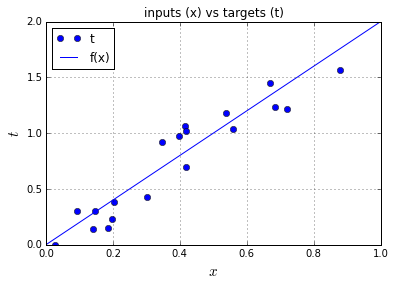

In [3]:
# Plot the target t versus the input x
plt.plot(x, t, 'o', label='t')
# Plot the initial line
plt.plot([0, 1], [f(0), f(1)], 'b-', label='f(x)')
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$t$', fontsize=15)
plt.ylim([0,2])
plt.title('inputs (x) vs targets (t)')
plt.grid()
plt.legend(loc=2)
plt.show()

## Define the cost function

We will optimize the model $\mathbf{y} = \mathbf{x} * w$ by tuning parameter $w$ so that the [squared error cost](http://en.wikipedia.org/wiki/Euclidean_distance#Squared_Euclidean_distance) along all samples is minimized. The squared error cost is defined as $\xi = \sum_{i=1}^{N} \Vert t_i - y_i \Vert ^2$, with $N$ the number of samples in the training set. The optimization goal is thus:  $\underset{w}{\text{argmin}} \sum_{i=1}^{N} \Vert t_i - y_i \Vert^2$.   
Notice that we take the sum of errors over all samples, which is known as batch training. We could also update the parameters based upon one sample at a time, which is known as online training.

This cost function for variable $w$ is plotted in the figure below. The value $w=2$ is at the minimum of the cost function (bottom of the parabola), this value is the same value as the slope we choose for $f(x)$. Notice that this function is [convex](http://en.wikipedia.org/wiki/Convex_function) and that there is only one minimum: the global minimum. While every squared error cost function for linear regression is convex, this is not the case for other models and other cost functions.

The neural network model is implemented in the `nn(x, w)` function, and the cost function is implemented in the `cost(y, t)` function.

In [4]:
# Define the neural network function y = x * w
def nn(x, w): return x * w

# Define the cost function
def cost(y, t): return ((t - y)**2).sum()

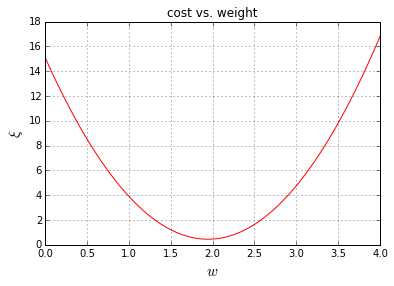

In [5]:
# Plot the cost vs the given weight w

# Define a vector of weights for which we want to plot the cost
ws = numpy.linspace(0, 4, num=100)  # weight values
cost_ws = numpy.vectorize(lambda w: cost(nn(x, w) , t))(ws)  # cost for each weight in ws

# Plot
plt.plot(ws, cost_ws, 'r-')
plt.xlabel('$w$', fontsize=15)
plt.ylabel('$\\xi$', fontsize=15)
plt.title('cost vs. weight')
plt.grid()
plt.show()

## Optimizing the cost function

For a simple cost function like in this example, you can see by eye what the optimal weight should be. But the error surface can be quite [complex](https://en.wikipedia.org/wiki/Rastrigin_function) or have a high dimensionality (each parameter adds a new dimension). This is why we use [optimization techniques](https://en.wikipedia.org/wiki/Mathematical_optimization) to find the minimum of the error function.

### Gradient descent

One optimization algorithm commonly used to train neural networks is the [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) algorithm. The gradient descent algorithm works by taking the [derivative](http://en.wikipedia.org/wiki/Derivative) of the cost function $\xi$ with respect to the parameters at a specific position on this cost function, and updates the parameters in the direction of the negative [gradient](http://en.wikipedia.org/wiki/Gradient). The parameter $w$ is iteratively updated by taking steps proportional to the negative of the gradient:
$$w(k+1) = w(k) - \Delta w(k)$$

With $w(k)$ the value of $w$ at iteration $k$ during the gradient descent.  
$\Delta w$ is defined as:

$$\Delta w = \mu \frac{\partial \xi}{\partial w}$$

With $\mu$ the learning rate, which is how big of a step you take along the gradient, and ${\partial \xi}/{\partial w}$ the gradient of the cost function $\xi$ with respect to the weight $w$. For each sample $i$ this gradient can be splitted according to the [chain rule](http://en.wikipedia.org/wiki/Chain_rule) into:

$$\frac{\partial \xi_i}{\partial w} = \frac{\partial y_i}{\partial w} \frac{\partial \xi_i}{\partial y_i}$$

Where $\xi_i$ is the squared error cost, so the ${\partial \xi_i}/{\partial y_i}$ term can be written as:

$$\frac{\partial \xi_i}{\partial y_i} = \frac{\partial (t_i - y_i)^2}{\partial y_i} = - 2 (t_i - y_i) = 2 (y_i - t_i)$$

And since $y_i = x_i * w$ we can write ${\partial y_i}/{\partial w}$ as:

$$\frac{\partial y_i}{\partial w} = \frac{\partial (x_i * w)}{\partial w} = x_i $$

So the full update function $\Delta w$ for sample $i$ will become:

$$\Delta w = \mu * \frac{\partial \xi_i}{\partial w} = \mu * 2 x_i (y_i - t_i)$$

In the batch processing, we just add up all the gradients for each sample:

$$\Delta w = \mu * 2 * \sum_{i=1}^{N} x_i (y_i - t_i)$$


To start out the gradient descent algorithm, you typically start with picking the initial parameters at random and start updating these parameters with $\Delta w$ until convergence. The learning rate needs to be tuned separately as a hyperparameter for each neural network.

The gradient ${\partial \xi}/{\partial w}$ is implemented by the `gradient(w, x, t)` function. $\Delta w$ is computed by the `delta_w(w_k, x, t, learning_rate)`. The loop below performs 4 iterations of gradient descent while printing out the parameter value and current cost.

In [6]:
# define the gradient function. Remember that y = nn(x, w) = x * w
def gradient(w, x, t): 
    return 2 * x * (nn(x, w) - t)

# define the update function delta w
def delta_w(w_k, x, t, learning_rate):
    return learning_rate * gradient(w_k, x, t).sum()

# Set the initial weight parameter
w = 0.1
# Set the learning rate
learning_rate = 0.1

# Start performing the gradient descent updates, and print the weights and cost:
nb_of_iterations = 4  # number of gradient descent updates
w_cost = [(w, cost(nn(x, w), t))] # List to store the weight,costs values
for i in range(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)  # Get the delta w update
    w = w - dw  # Update the current weight parameter
    w_cost.append((w, cost(nn(x, w), t)))  # Add weight,cost to list

# Print the final w, and cost
for i in range(0, len(w_cost)):
    print('w({}): {:.4f} \t cost: {:.4f}'.format(i, w_cost[i][0], w_cost[i][1]))

w(0): 0.1000 	 cost: 13.6197
w(1): 1.5277 	 cost: 1.1239
w(2): 1.8505 	 cost: 0.4853
w(3): 1.9234 	 cost: 0.4527
w(4): 1.9399 	 cost: 0.4510


Notice in the previous outcome that the gradient descent algorithm quickly converges towards the target value around $2.0$. Let's try to plot these iterations of the gradient descent algorithm to visualize it more.

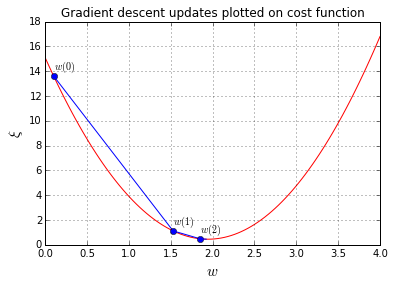

In [7]:
# Plot the first 2 gradient descent updates
plt.plot(ws, cost_ws, 'r-')  # Plot the error curve
# Plot the updates
for i in range(0, len(w_cost)-2):
    w1, c1 = w_cost[i]
    w2, c2 = w_cost[i+1]
    plt.plot(w1, c1, 'bo')
    plt.plot([w1, w2],[c1, c2], 'b-')
    plt.text(w1, c1+0.5, '$w({})$'.format(i)) 
# Show figure
plt.xlabel('$w$', fontsize=15)
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Gradient descent updates plotted on cost function')
plt.grid()
plt.show()

#### Gradient descent updates

The last figure shows the gradient descent updates of the weight parameters for 2 iterations. The blue dots represent the weight parameter values $w(k)$ at iteration $k$. Notice how the update differs from the position of the weight and the gradient at that point. The first update takes a much larger step than the second update because the gradient at $w(0)$ is much larger than the gradient at $w(1)$.

The regression line fitted by gradient descent with 10 iterations is shown in the figure below. The fitted line (red) lies close to the original line (blue), which is what we tried to approximate via the noisy samples. Notice that both lines go through point $(0,0)$, this is because we didn't have a bias term, which represents the intercept, the intercept at $x=0$ is thus $t=0$.

In [8]:
w = 0
# Start performing the gradient descent updates
nb_of_iterations = 10  # number of gradient descent updates
for i in range(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)  # get the delta w update
    w = w - dw  # update the current weight parameter

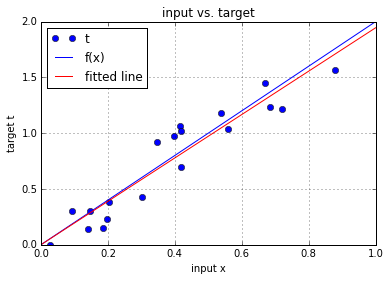

In [9]:
# Plot the fitted line agains the target line
# Plot the target t versus the input x
plt.plot(x, t, 'o', label='t')
# Plot the initial line
plt.plot([0, 1], [f(0), f(1)], 'b-', label='f(x)')
# plot the fitted line
plt.plot([0, 1], [0*w, 1*w], 'r-', label='fitted line')
plt.xlabel('input x')
plt.ylabel('target t')
plt.ylim([0,2])
plt.title('input vs. target')
plt.grid()
plt.legend(loc=2)
plt.show()

This post at [peterroelants.github.io](http://peterroelants.github.io/posts/neural_network_implementation_part01/) is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/neural_net_implementation/neural_network_implementation_part01.ipynb)